In [7]:
import random
import sys
from pathlib import Path

import albumentations as aug
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau,
    TensorBoard,
)
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img

sys.path.insert(0, "..")

import src.data.cityscapes as cityscapes_data
import src.models.cityscapes as cityscapes_mod
import src.visualization.cityscapes as cityscapes_viz


In [8]:
size_pixels = 64

img_size = (size_pixels, size_pixels)
num_classes = 8
batch_size = 32
original_size = (2048, 1024)

# Image augmentation : None for no augmentation
augment = aug.Compose(
    [
        # aug.OneOf(  # Weather augmentations
        #     [
        #         aug.RandomRain(),
        #         aug.RandomFog(),
        #         aug.RandomShadow(),
        #         aug.RandomSnow(),
        #         aug.RandomSunFlare(),
        #     ]
        # ),
        aug.OneOf(  # Color augmentations
            [
                aug.RandomBrightnessContrast(),
                aug.RandomGamma(),
                aug.RandomToneCurve(),
            ]
        ),
        aug.OneOf(  # Camera augmentations
            [
                aug.MotionBlur(),
                aug.GaussNoise(),
            ]
        ),
        aug.OneOf(  # Geometric augmentations
            [
                aug.HorizontalFlip(),
                aug.RandomCrop(
                    width=int(img_size[0] / random.uniform(1.0, 3.0)),
                    height=int(img_size[1] / random.uniform(1.0, 3.0)),
                ),
                aug.SafeRotate(
                    limit=15,
                ),
            ]
        ),
        aug.Resize(
            width=img_size[0],
            height=img_size[1],
        ),
    ]
)

model_name = (
    f"unet_xception_{size_pixels}{'_augmented' if augment is not None else ''}"
)
model_path = Path("./../results/", model_name)


In [9]:
raw_data_path = Path("./../data/raw")
leftImg8bit_path = Path(raw_data_path, "leftImg8bit")
gtFine_path = Path(raw_data_path, "gtFine")


# Train dataset
train_input_img_paths = sorted(
    Path(leftImg8bit_path, "train").glob("**/*.png")
)
train_label_ids_img_paths = sorted(
    Path(gtFine_path, "train").glob("**/*_labelIds.png")
)
train_label_colors_img_paths = sorted(
    Path(gtFine_path, "train").glob("**/*_color.png")
)

# Validation dataset
val_input_img_paths = sorted(
    Path(leftImg8bit_path, "val").glob("**/*.png")
)
val_label_ids_img_paths = sorted(
    Path(gtFine_path, "val").glob("**/*_labelIds.png")
)
val_label_colors_img_paths = sorted(
    Path(gtFine_path, "val").glob("**/*_color.png")
)

# Test dataset
test_input_img_paths = sorted(
    Path(leftImg8bit_path, "test").glob("**/*.png")
)
test_label_ids_img_paths = sorted(
    Path(gtFine_path, "test").glob("**/*_labelIds.png")
)
test_label_colors_img_paths = sorted(
    Path(gtFine_path, "test").glob("**/*_color.png")
)


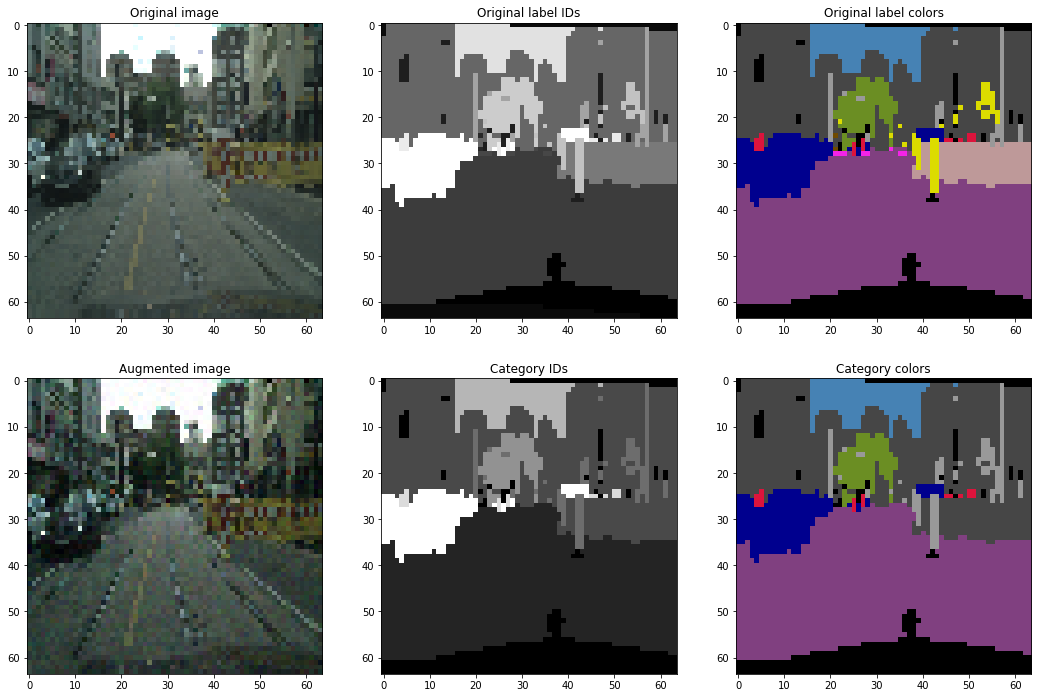

In [10]:
rand_idx = np.random.randint(0, len(train_input_img_paths))


fig, ax = plt.subplots(
    nrows=2,
    ncols=3,
    figsize=(18, 12),
)

ax[0, 0].title.set_text("Original image")
input_img = load_img(train_input_img_paths[rand_idx], target_size=img_size)
ax[0, 0].imshow(input_img)

ax[0, 1].title.set_text("Original label IDs")
label_ids = load_img(
    train_label_ids_img_paths[rand_idx],
    target_size=img_size,
    color_mode="grayscale",
)
ax[0, 1].imshow(label_ids, cmap="gray")

ax[0, 2].title.set_text("Original label colors")
input_colors = load_img(
    train_label_colors_img_paths[rand_idx], target_size=img_size
)
ax[0, 2].imshow(input_colors)

if augment is not None:
    augmented = augment(
        image=np.array(input_img),
        mask=np.expand_dims(
            cityscapes_data.cityscapes_label_ids_to_category_ids(np.array(label_ids)),
            2,
        ),
    )

    ax[1, 0].title.set_text("Augmented image")
    ax[1, 0].imshow(augmented["image"])

    category_ids = augmented["mask"]
else:
    category_ids = cityscapes_data.cityscapes_label_ids_to_category_ids(np.array(label_ids))

ax[1, 1].title.set_text("Category IDs")
ax[1, 1].imshow(category_ids, cmap="gray")

ax[1, 2].title.set_text("Category colors")
category_colors = cityscapes_data.cityscapes_category_ids_to_category_colors(
    np.squeeze(category_ids)
)
ax[1, 2].imshow(category_colors)

plt.show()


In [11]:
from keras_segmentation.pretrained import pspnet_50_ADE_20K , pspnet_101_cityscapes, pspnet_101_voc12

# model = pspnet_50_ADE_20K() # load the pretrained model trained on ADE20k dataset

model = pspnet_101_cityscapes() # load the pretrained model trained on Cityscapes dataset

# model = pspnet_101_voc12() # load the pretrained model trained on Pascal VOC 2012 dataset

# load any of the 3 pretrained models

out = model.predict_segmentation(
    inp=train_input_img_paths[rand_idx],
    out_fname="out.png"
)


AttributeError: module 'keras.utils' has no attribute 'get_file'

In [ ]:

# Free up RAM in case the model definition cells were run multiple times
clear_session()

# Build model
if Path(model_path, "model").exists():
    model = load_model(
        Path(model_path, "model"),
        custom_objects={
            "UpdatedMeanIoU": cityscapes_mod.UpdatedMeanIoU,
            "jaccard_loss": cityscapes_mod.jaccard_loss,
        },
    )
else:
    model = cityscapes_mod.unet_xception_model(img_size, num_classes, model_name=model_name)

model.summary()


In [ ]:
# Configure the model for training.
model.compile(
    optimizer="adam",
    loss=cityscapes_mod.jaccard_loss,  # "sparse_categorical_crossentropy",
    metrics=[
        cityscapes_mod.MeanIoU(
            name="MeanIoU", num_classes=num_classes
        ),  # https://ilmonteux.github.io/2019/05/10/segmentation-metrics.html
    ],
)

model_checkpoint_path = Path(model_path, "checkpoint.h5")
if model_checkpoint_path.exists():
    print("Loading model from {}".format(model_checkpoint_path))
    model.load_weights(str(model_checkpoint_path))

# Train the model, doing validation at the end of each epoch.
model.fit(
    cityscapes_data.CityscapesGenerator(
        batch_size, img_size, train_input_img_paths, train_label_ids_img_paths
    ),
    validation_data=cityscapes_data.CityscapesGenerator(
        batch_size, img_size, val_input_img_paths, val_label_ids_img_paths
    ),
    epochs=100,
    callbacks=[
        ModelCheckpoint(
            model_checkpoint_path,
            save_best_only=True,
            verbose=1,
        ),
        ReduceLROnPlateau(
            patience=1,
            factor=0.5,
            min_delta=1e-3,
            min_lr=1e-9,
            verbose=1,
        ),
        EarlyStopping(
            patience=3,
            restore_best_weights=True,
            min_delta=1e-5,
            verbose=1,
        ),
        TensorBoard(log_dir=Path(model_path, "logs")),
        cityscapes_viz.CityscapesViewerCallback(
            val_input_img_paths, val_label_colors_img_paths, img_size
        ),
    ],
    # workers=2,
    # use_multiprocessing=True,
)

model.save(Path(model_path, "model"))
